# Manipulation algorithm
This notebook will apply Algorithm 1 to a given profile of voters and candidates. A notebook format is used to provide commentary and illustrate step-by-step the process in the algorithm. 

In [35]:
#Key package imports
from itertools import permutations
import spatialGeneration
import itertools
import csv
import copy
import math
import matplotlib.pyplot as plt
import time

In [2]:
def setup():
    """setup()
    Takes the number of candidates, current voter rankings and coalition size.
    Creates a dictionary with the current votes for each candidate, and a list
    of potential elimination orders."""

    # list of ordered votes that we already know about
    """voter1 = {"A":1, "B": 2, "C": 3, "D": 4}
    voter2 = {"A":3, "B": 1, "C": 2, "D": 4}
    voter3 = {"A":1, "B": 2, "C": 3, "D": 4}
    voting_array = [voter1,voter2,voter3]"""
    
    voting_array = []
    #read csv for list of ordered votes that we already know about
    #with open("Exports/Export1678356411.497025.csv","r",newline='\n') as file:
    #    reader = csv.reader(file, delimiter=',')
    #    candidates = next(reader)
    #    #print(candidates)
    #    number_of_cands = len(candidates)
    #    for row in reader:
            #print(row)
    #        Vote = dict(zip(candidates,[int(i) for i in row]))
    #        voting_array.append(Vote)
            #print(voting_array)
    voting_array = copy.deepcopy(gen_Ranking)
    candidates = copy.deepcopy(gen_Candidates)
    #voting_array.pop(0) #necessary to delete headers
    #print(voting_array)
    candidates_and_votes = tally_votes(voting_array, candidates)

    # potential orders of elimination of candidates
    elimination_orders= []
    # Get permutations of n-1 candidates
    cand = list(candidates_and_votes.keys())
    perms_of_candidates = permutations(cand[0:len(candidates)-1])
    for i in perms_of_candidates:
        x = list(i)+[cand[-1]]
        elimination_orders.append(x)
    #print("orders: ",elimination_orders)
    #print(candidates_and_votes,voting_array)
    return candidates_and_votes, elimination_orders, voting_array, candidates

In [3]:
def tally_votes(v_array, candidates):
    # the candidates and the number of 1st choice votes they have
    candidates_and_votes = {candidates[i]:0 for i in range(0,len(candidates))}
    #print(candidates_and_votes)
    
    # add each voter's current 1st choice to the voting_array
    #print(voting_array)
    for voter in v_array:
        #print(voter)
        for key in voter:
            if voter[key]==1:
                candidates_and_votes[key]+=1
    return(candidates_and_votes)

In [4]:
def remove_orders(unsuccesful_start):
    elimination_orders_remove = []
    k = len(unsuccesful_start) 
    copy = elimination_orders.copy()
    for i in copy:
        if i[0:k] == unsuccesful_start:
            elimination_orders.remove(i)

In [5]:
def check_order(candidates_and_votes, order, col_size, voting_array, candidates):
    coalition_size = copy.deepcopy(col_size)
    voting_array_c = copy.deepcopy(voting_array)
    #print("HERE",candidates_and_votes)
    coalition_votes = []
    coalition_store = []
    dic__coalition_votes = []
    eliminated_candidates = []
    candidates_remaining = copy.deepcopy(candidates)
    for i in range(0,coalition_size):
        coalition_votes.append([])
    count = 1
    # copy of candidates and votes
    variable_votes = dict(candidates_and_votes)
    for i in order:
        eliminated_candidates.append(i)
        for j in order[order.index(i)+1:]:
            # compute votes required for j to beat i
            votes_req = int(variable_votes[i]) - int(variable_votes[j]) + 1
            # check that difference is positive
            if votes_req > 0:
                if len(coalition_votes) >= votes_req: # check if coalition size >= votes required to make j beat i
                    variable_votes[j] += votes_req
                    # decrease the amount of votes we can maniplulate this round
                    for c in range(0,votes_req):
                        coalition_votes[0].append(j)
                        coalition_store.append(coalition_votes[0])
                        coalition_votes.remove(coalition_votes[0])

                else:
                    # coalition was too small
                    remove_orders(eliminated_candidates)
                    #print("Elimination order is impossible", order)
                    return "fail","fail"
                    #return [], ord
        candidates_remaining.remove(i)
        if count <= len(order): # no point in doing the very last step of redistrbuting
            for en, voter in enumerate(voting_array_c):
                # Changes any first preference votes to the next available candidate in their preference order
                if voter[i] == 1:
                    voting_array_c[en] = {key: voter[key]-1 for key in voter}
        
                else:
                    # Eliminate candidate i from everyone elses list   
                    voting_array_c[en][i]=0                            
                    for key, value in voter.items():
                        """
                        print("i:",i," ",type(i),"\n",
                              "voter:",voter," ",type(voter),
                              "key:",key," ",type(key),"\n",
                              "value:",value, " ", type(key))"""
                        if int(value) > int(voter[i]):
                            voting_array_c[en][key] += -1
                count +=1
        #print(coalition_store)
        for b in coalition_store:
            if list(set(b).intersection(set(candidates_remaining))) == []:
                coalition_votes.insert(0,b)
                coalition_store.remove(b)
            # voters in coalitions next spot available to be filled
            
            
    coalition_votes += coalition_store
    #print("Successful Manipulation: ", ord)
    for v in coalition_votes:
        
        back_ord = order[::-1]
        #print("BACK ORD:",back_ord)
        dif = list(sorted(set(back_ord) - set(v), key=order.index))
        #print("V:",v)
        v += dif[::-1]
        #print("V+dif:",v)
        #print("NEW DICT:",{key: value+1 for value, key in enumerate(v)})
        dic__coalition_votes.append({key: value+1 for value, key in enumerate(v)})
        #print(order)
        #print({key: value+1 for value, key in enumerate(v)})
    return dic__coalition_votes, order

In [6]:
def check_manipulation(votes, k, candidates):
    all_votes = votes
    #print("CHECK MANIPULATION OF: ")
    # loop over number of eliminations (n-1 candidates)
    for i in range(0,k-1):
        #print(candidates)
        c_and_v = tally_votes(all_votes, candidates)
        #print("\n c_and_v: ",c_and_v)
        # there can't be ties by construction 
        # needs changing to elimate all candidates with votes = 0 / minimum, and change to while loop (while not just one candidate left with none-zero votes - what if tie?)
        if i == 0:
            elim_cand = min(c_and_v, key=c_and_v.get) #get candidate with least 1st choice votess
        else:
            elim_cand = min(x for x in c_and_v if  c_and_v[x] != 0)
        for en, vote_dict in enumerate(all_votes):
            #print("before", vote_dict)
            #print(elim_cand)
            # Changes any first preference votes to the next available candidate in their preference order
            if vote_dict[elim_cand] == 1:
                all_votes[en] = {key: vote_dict[key]-1 for key in vote_dict}
                all_votes[en].pop(elim_cand)
            else:
                # Eliminate candidate i from everyone elses list
                #all_votes[en][elim_cand] = 0
                for key, value in vote_dict.items():
                    if value > vote_dict[elim_cand]:
                        all_votes[en][key] += -1
                all_votes[en].pop(elim_cand)
           # print("after", all_votes[en])
        candidates.remove(elim_cand)
    #print("CANDIDATES",candidates)
    c_and_v = tally_votes(all_votes, candidates)
    #print("\n c_and_v: ",c_and_v)  
    #print(c_and_v,"\n")

    return (max(c_and_v, key=c_and_v.get))


In [7]:
#setup()

In [8]:
#coalition_array = []
#candidates_and_votes, elimination_orders, voting_array,candidates = setup()
#coalition_size = 2000

#for order in elimination_orders:
#    a,b = check_order(candidates_and_votes, order, coalition_size, voting_array,candidates)
#    #print("a: ",a)
#    #print("b: ",b)
#    #coalition_array.append([a,b])
#    if b != "fail":
#        y, yy, yyy,yyyy = setup()
#        check_votes = yyy + a
#       winner = check_manipulation(check_votes,len(yyyy),yyyy)
#        print(b, winner)

In [9]:
#gen_Ranking,gen_Candidates = spatialGeneration.returnRankings(5,100)

### Varying K

In [13]:
gen_Ranking, gen_Candidates = spatialGeneration.returnRankings(5,100)

In [14]:
candidates_and_votes, elimination_orders, va, candidates = setup()
#coalition_size = 490
#MR = 0
def Cal_MR_K(col):
    MR = 0
    candidates_and_votes, elimination_orders, va, candidates = setup()
    for order in elimination_orders:
        a,b = check_order(candidates_and_votes, order, col, va, gen_Candidates)
        if a != "fail":
            MR += 1
    return MR/(math.factorial(len(gen_Candidates)-1))

24


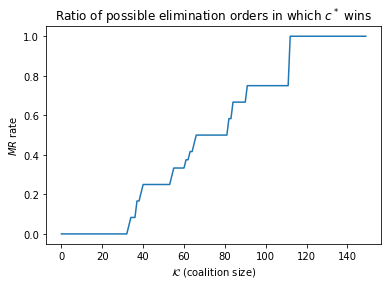

In [21]:
print(math.factorial(len(gen_Candidates)-1))

store = []
for r in range(0,150):
    #candidates_and_votes, elimination_orders, va, candidates = setup()
    store.append(Cal_MR_K(r))
#print(elimination_orders)
plt.plot(range(0,150),store)
plt.ylabel("$MR$ rate")
plt.xlabel("$\mathcal{K}$ (coalition size)")
plt.title("Ratio of possible elimination orders in which $c^*$ wins")
plt.show()

In [73]:
START = time.time()
stores = []
runs=20
for j in range(0,runs):
    print(j)
    gen_Ranking, gen_Candidates = spatialGeneration.returnRankings(9,100)
    print("Generation successful. Time elapsed",round(time.time()-START,1))
    candidates_and_votes, elimination_orders, va, candidates = setup()
    def Cal_MR_K(col):
        MR = 0
        candidates_and_votes, elimination_orders, va, candidates = setup()
        for order in elimination_orders:
            a,b = check_order(candidates_and_votes, order, col, va, gen_Candidates)
            if a != "fail":
                MR += 1
        return MR/(math.factorial(len(gen_Candidates)-1))

    store = []
    for r in range(0,150):
        #candidates_and_votes, elimination_orders, va, candidates = setup()
        if r%1==0:
            store.append(Cal_MR_K(r))
            print("Run: ",j,"of",runs, "k: ",r, "Time elapsed: ", round(time.time()-START,1))
        else:
            store.append(store[-1])
    
    
    stores.append(store)
    plt.plot(range(0,150),store)
    
plt.ylabel("$MR$ rate")
plt.xlabel("$\mathcal{K}$ (coalition size)")
plt.title("Ratio of possible elimination orders in which $c^*$ wins")
plt.show()

0
Generation successful. Time elapsed 0.1
Run:  0 of 20 k:  0 Time elapsed:  102.5
Run:  0 of 20 k:  1 Time elapsed:  134.2
Run:  0 of 20 k:  2 Time elapsed:  167.1
Run:  0 of 20 k:  3 Time elapsed:  199.8
Run:  0 of 20 k:  4 Time elapsed:  232.7
Run:  0 of 20 k:  5 Time elapsed:  267.6
Run:  0 of 20 k:  6 Time elapsed:  303.0
Run:  0 of 20 k:  7 Time elapsed:  338.4
Run:  0 of 20 k:  8 Time elapsed:  373.8
Run:  0 of 20 k:  9 Time elapsed:  409.3
Run:  0 of 20 k:  10 Time elapsed:  444.7
Run:  0 of 20 k:  11 Time elapsed:  480.1
Run:  0 of 20 k:  12 Time elapsed:  515.5
Run:  0 of 20 k:  13 Time elapsed:  550.9
Run:  0 of 20 k:  14 Time elapsed:  586.4
Run:  0 of 20 k:  15 Time elapsed:  621.9
Run:  0 of 20 k:  16 Time elapsed:  657.4
Run:  0 of 20 k:  17 Time elapsed:  692.7
Run:  0 of 20 k:  18 Time elapsed:  726.8
Run:  0 of 20 k:  19 Time elapsed:  761.1
Run:  0 of 20 k:  20 Time elapsed:  795.1
Run:  0 of 20 k:  21 Time elapsed:  830.3
Run:  0 of 20 k:  22 Time elapsed:  865.5
Ru

KeyboardInterrupt: 

In [71]:
for k in range(runs):
    csv_file = "Exports/C7V10000/C5V10000_"+str(k)+".csv"
    with open(csv_file, 'w',newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(stores[k])

IndexError: list index out of range

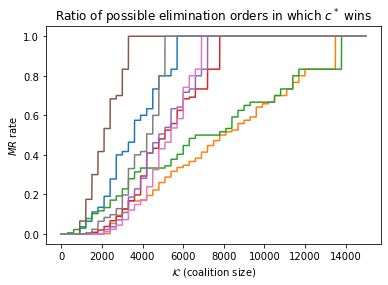

In [72]:
for i in range(0,8):
    plt.plot(range(0,15000),stores[i])    
plt.ylabel("$MR$ rate")
plt.xlabel("$\mathcal{K}$ (coalition size)")
plt.title("Ratio of possible elimination orders in which $c^*$ wins")
plt.show()